## Dealing with data classification

We will be using Porto Seguro’s Safe Driver Prediction data from Kaggle
https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data

In [1]:
!pip install opendatasets --upgrade --quiet


In [4]:
##  Go to the Kaggle website and find the data set you want to download. Click Late Submission and agree to the terms and conditions.
##  Copy the URL of the data set and paste it into the code below.
##  Go to https://www.kaggle.com/settings/account and generate a new api token. This will download a kaggle.json file. 
##  Place it in the same directory as this notebook.
import pandas as pd
import opendatasets as od
# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data'
# Using opendatasets let's download the data sets
od.download(dataset)

100%|██████████| 76.5M/76.5M [00:32<00:00, 2.44MB/s]



Extracting archive ./porto-seguro-safe-driver-prediction/porto-seguro-safe-driver-prediction.zip to ./porto-seguro-safe-driver-prediction


We're going to use the Pandas library to open the file. Pandas is a powerful and commonly used Python library for manipulating and understanding data. Let's take a glimpse at the data.

In [ ]:
df_train.head()

You can see that the first column is an anonymized ID, and the second is the target (outcome). The target represents whether the individual made a claim (1) or not (0).

## Class imbalance

Let's look at how many cases there are of each class (here a 0 or 1)

In [ ]:
target_count = df_train.target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

In [ ]:
target_count.plot(kind='bar', title='Count (target)')

## The accuracy trap

For brevity, here we simply use an xgboost classifier (gradient boosted decision trees) that we train on the data. The same principle applies to using any machine learning approach, including evolutionary algorithms.

In [ ]:
from xgboost import XGBClassifier

# Remove 'id' and 'target' columns
labels = df_train.columns[2:]
X = df_train[labels] # get all columns except 'id' and 'target'
y = df_train['target']

Next we divide the data into a training and test sets using sklearn.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Now we train the classifier. This is where your evolutionary algorithm would go.

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train)

Finally, we get the predictions from the model and look at the accuracy of the results. Remember that the accuracy of the results is the proportion of correctly classified cases.

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Now let's run the same code, but using only one feature (column). You'd expect this to drastically reduce the accuracy of the classifier.

In [ ]:
model = XGBClassifier()
model.fit(X_train[['ps_calc_01']], y_train)
y_pred = model.predict(X_test[['ps_calc_01']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

## What is going on?!

Below we will work out the confusion matrix for the one-feature example.

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

This shows the correct and incorrect predictions for each class. The first row is for class 0 (no claim) and the second row for class 1 (claim). The columns indicate the predicted class. So what we want is zeros on one diaganal and high numbers on the other.

From the output above, you can see that the algorithm is simply guessing that there will be no claim every time. This is because most cases involve no claim, and so it gets a high accuracy doing this.

This is the impact of **class imbalance**.

## Resampling datasets

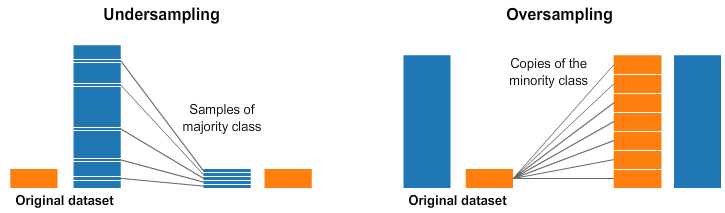

Any resampling should only be done on the training data (e.g. not the test data).

# Random under-sampling

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_train, test_size=0.2, random_state=1)

In [ ]:
df_train = pd.DataFrame(data=df_train)

count_class_0, count_class_1 = df_train.target.value_counts()

In [ ]:
# Divide by class
df_class_0 = df_train[df_train['target'] == 0]
df_class_1 = df_train[df_train['target'] == 1]

In [ ]:
print('Before sampling:')
print(df_train.target.value_counts())

In [ ]:
df_class_0_under = df_class_0.sample(count_class_1)
df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_train_under.target.value_counts())

The problem here is loss of data.

## Random over-sampling

In [ ]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)

In [ ]:
df_train_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_train_over.target.value_counts())

The problem here is the potential for overfitting.

# Combining under sampling and over sampling

Under sample class 0

In [ ]:
count_class_0

In [ ]:
size_to_reduce_0_to = round(count_class_0 / 2)
df_class_0_under = df_class_0.sample(size_to_reduce_0_to)
count_class_0 = size_to_reduce_0_to

Over sample class 1

In [ ]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)

In [ ]:
df_train_over_under = pd.concat([df_class_0_under, df_class_1_over], axis=0)

In [ ]:
print('Random combined-sampling:')
print(df_train_over_under.target.value_counts())

Now let's go back to our code above and see what difference this has made to the accuracy scores.

# Running on the resampled data

Remember that we have already split the data into training and testing and only resampled the training data.

In [ ]:
df_train = df_train_over_under

In [ ]:
labels = df_train.columns[2:]
X_train = df_train[labels]
y_train = df_train['target']

labels = df_train.columns[2:]
X_test = df_test[labels]
y_test = df_test['target']

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

Note that the overall accuracy has gone down from before we subsampled. This is because the algorithm can't as easily get away with always guessing 0 on the training set.

Now let's test on our one-feature example.

In [ ]:
model = XGBClassifier()
model.fit(X_train[['ps_calc_01']], y_train)
y_pred = model.predict(X_test[['ps_calc_01']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))